
# Khai báo các thư viện cần sử dụng.

In [ ]:
!pip install keras numpy
!pip install tensorflow


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from google.colab import drive
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [ ]:
# mount drive
drive.mount('/content/drive')


Mounted at /content/drive


# Load dữ liệu .csv

In [ ]:
# Đọc dữ liệu từ các tập tin CSV
file_csv_path = ('/content/drive/My Drive/Colab Notebooks/XuLyAnh/BTL/Handwritten_Data.csv')

# Đọc dữ liệu từ CSV
data = pd.read_csv(file_csv_path)

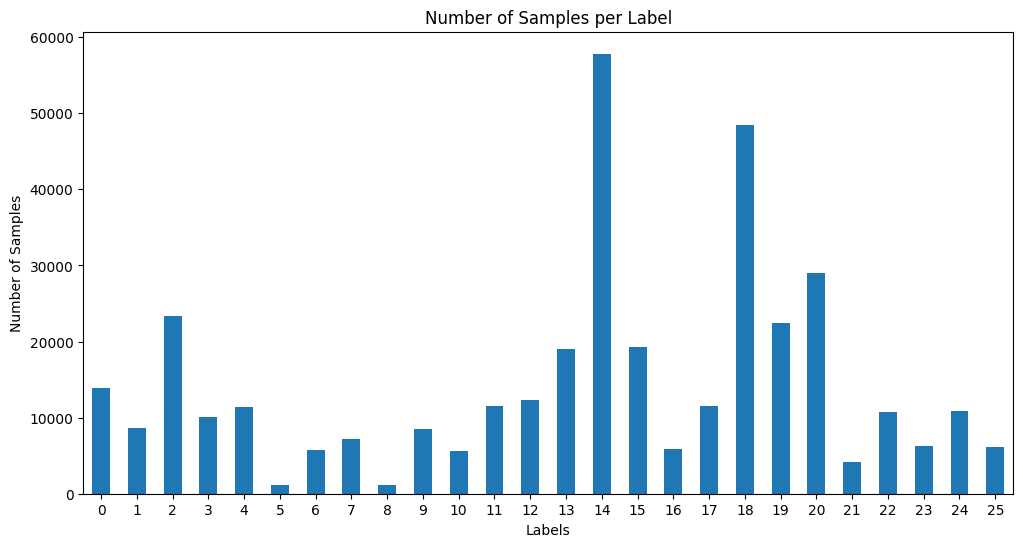

In [ ]:
# Đếm số lượng mẫu cho mỗi nhãn
label_counts = data['0'].value_counts().sort_index()

# Vẽ biểu đồ dạng cột
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Label')
plt.xticks(rotation=0)
plt.show()

In [ ]:
X = data.iloc[:, 1:].values  # Các cột còn lại là các giá trị pixel
y = data.iloc[:, 0].values  # Cột đầu tiên là nhãn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(238368, 784)
(74490, 784)
(59592, 784)


# Cân bằng dữ liệu bằng SMOTE

In [ ]:
# Định nghĩa kích thước của từng phần nhỏ (ví dụ: 50,000 mẫu mỗi lần)
chunk_size = 10000

# Sử dụng SMOTE trên từng phần nhỏ
smote = SMOTE(random_state=42, k_neighbors=5)

# Tạo file CSV để lưu trữ dữ liệu resample (sử dụng chế độ ghi đè)
output_file = ('/content/drive/My Drive/Colab Notebooks/XuLyAnh/BTL/Handwritten_Data_Add.csv')

# Mở file ở chế độ ghi
with open(output_file, 'w') as f:
    # Ghi tiêu đề (cột nhãn và các cột pixel)
    header = data.columns
    f.write(','.join(header) + '\n')

    for start in range(0, X_train.shape[0], chunk_size):
        end = min(start + chunk_size, X_train.shape[0])
        X_chunk = X_train[start:end]
        y_chunk = y_train[start:end]

        # Kiểm tra số lượng mẫu trong mỗi lớp
        unique, counts = np.unique(y_chunk, return_counts=True)
        class_counts = dict(zip(unique, counts))

        # Điều chỉnh k_neighbors nếu cần thiết
        min_class_count = min(class_counts.values())
        k_neighbors = min(5, max(1, min_class_count - 1))

        # Sử dụng SMOTE với k_neighbors điều chỉnh
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)

        try:
            X_resampled_chunk, y_resampled_chunk = smote.fit_resample(X_chunk, y_chunk)

            # Chuyển đổi thành DataFrame
            df_resampled_chunk = pd.DataFrame(np.hstack((y_resampled_chunk.reshape(-1, 1), X_resampled_chunk)))

            # Ghi dữ liệu vào file CSV
            df_resampled_chunk.to_csv(f, header=False, index=False)
        except ValueError as e:
            print(f"Skipping chunk due to error: {e}")
            continue

In [ ]:
# Đọc dữ liệu từ các tập tin CSV
file_csv_path = ('/content/drive/My Drive/Colab Notebooks/XuLyAnh/BTL/Handwritten_Data_Add.csv')

# Đọc dữ liệu từ CSV
data = pd.read_csv(file_csv_path)

In [ ]:
# Đếm số lượng mẫu cho mỗi nhãn
label_counts = data['0'].value_counts().sort_index()

# Vẽ biểu đồ dạng cột
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Label')
plt.xticks(rotation=0)
plt.show()

# Reshape ảnh

In [ ]:
# Đảm bảo rằng dữ liệu có kích thước chính xác (28x28)
X_train = X_train.reshape(-1, 28, 28)  # Định hình lại thành các hình ảnh 28x28
X_test = X_test.reshape(-1, 28, 28)  # Định hình lại thành các hình ảnh 28x28
X_val = X_val.reshape(-1, 28, 28)  # Định hình lại thành các hình ảnh 28x28

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(238368, 28, 28)
(74490, 28, 28)
(59592, 28, 28)


# Reshape lại dữ liệu cho đúng kích thước mà keras yêu cầu.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

print ("Shape of X_train: {}".format(X_train.shape))
print ("Shape of y_train: {}".format(y_train.shape))

print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (238368, 28, 28, 1)
Shape of y_train: (238368,)
Shape of X_test: (74490, 28, 28, 1)
Shape of y_test: (74490,)


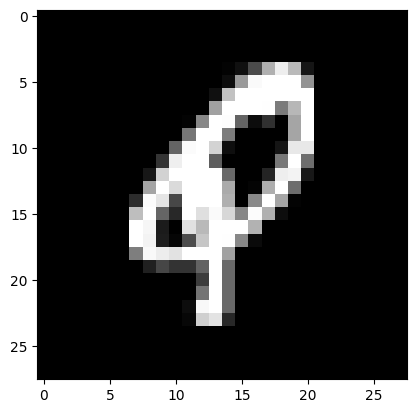

In [ ]:
example = X_train[50]
plt.imshow(example.reshape(28, 28), cmap="gray")
plt.show()

# Áp dụng thuật toán One hot encoding label (Y).

In [ ]:
lett_classes = 27
Y_train = to_categorical(y_train, lett_classes)
Y_val = to_categorical(y_val, lett_classes)
Y_test = to_categorical(y_test, lett_classes)

print('Dữ liệu y ban đầu ', y_train[0])
print('Dữ liệu y sau one-hot encoding ',Y_train[0])

Dữ liệu y ban đầu  18
Dữ liệu y sau one-hot encoding  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0.]


# Định nghĩa model.

In [ ]:
model = Sequential()

# Thêm Convolutional layer với 32 kernel, kích thước kernel 3*3.
model.add(Conv2D(32, (3, 3), activation='sigmoid', input_shape=(28,28,1)))

# Thêm Convolutional layer.
model.add(Conv2D(32, (3, 3), activation='sigmoid'))

# Thêm Max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer chuyển từ tensor sang vector.
model.add(Flatten())

# Thêm Fully Connected layer với 128 nodes và dùng hàm sigmoid.
model.add(Dense(128, activation='sigmoid'))

# Output layer với 27 node và dùng softmax function để chuyển sang xác suất.
model.add(Dense(27, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               589952    
                                                                 
 dense_1 (Dense)             (None, 27)                3483      
                                                        

# Compile model.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Thực hiện train model với data.

In [ ]:
H = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
batch_size=32, epochs=10, verbose=1)

Epoch 1/10
7449/7449 [==============================] - 41s 5ms/step - loss: 0.2053 - accuracy: 0.9483 - val_loss: 0.0814 - val_accuracy: 0.9781
Epoch 2/10
7449/7449 [==============================] - 34s 5ms/step - loss: 0.0599 - accuracy: 0.9836 - val_loss: 0.0650 - val_accuracy: 0.9824
Epoch 3/10
7449/7449 [==============================] - 36s 5ms/step - loss: 0.0405 - accuracy: 0.9888 - val_loss: 0.0508 - val_accuracy: 0.9854
Epoch 4/10
7449/7449 [==============================] - 35s 5ms/step - loss: 0.0290 - accuracy: 0.9918 - val_loss: 0.0419 - val_accuracy: 0.9882
Epoch 5/10
7449/7449 [==============================] - 35s 5ms/step - loss: 0.0210 - accuracy: 0.9942 - val_loss: 0.0385 - val_accuracy: 0.9901
Epoch 6/10
7449/7449 [==============================] - 35s 5ms/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.0387 - val_accuracy: 0.9890
Epoch 7/10
7449/7449 [==============================] - 34s 5ms/step - loss: 0.0127 - accuracy: 0.9963 - val_loss: 0.0388 - val_ac

# Vẽ đồ thị loss, accuracy của traning set và validation set

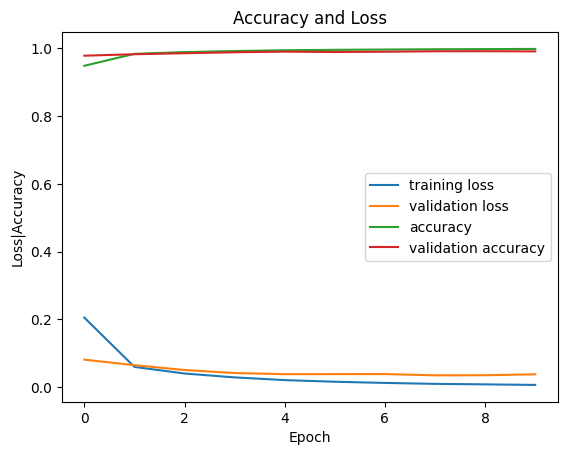

In [ ]:
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

# Đánh giá model với dữ liệu test

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)
print(score)

2328/2328 [==============================] - 7s 3ms/step - loss: 0.0353 - accuracy: 0.9916
[0.035283029079437256, 0.99155592918396]


# Lưu model.

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/XuLyAnh/BTL/mymodel.tflearn')

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/XuLyAnh/BTL/mymodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Dự đoán kết quả với tệp Test.

1/1 [==============================] - 0s 19ms/step


Final Output: 12
Kết quả nhận dạng giải mã:  m


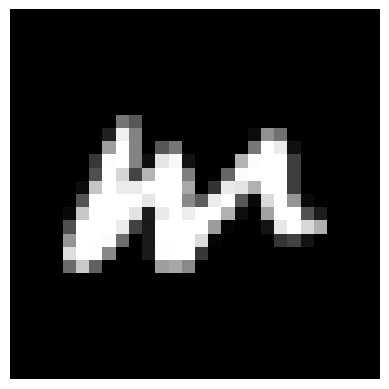

In [ ]:
example = X_train[170]

prediction = model.predict(example.reshape(1, 28, 28, 1))

print("\n\nFinal Output: {}".format(np.argmax(prediction)))
decoder_label([np.argmax(prediction)])
plt.imshow(example.reshape(28, 28), cmap="gray")
plt.axis('off')
plt.show()

# Gọi lại model đã train

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/XuLyAnh/BTL/mymodel.tflearn')

#Giải mã

In [ ]:
def decoder_label(arr):
  alphabet = list(string.ascii_lowercase)  # ['a', 'b', 'c', ..., 'z']

  # Tạo dictionary để ánh xạ số thứ tự với chữ cái
  dict_label = {i: alphabet[i] for i in range(26)}

  # Giải mã mảng số thành các chữ cái
  decoded_arr = [dict_label[i] for i in arr]

  # Chuyển mảng chữ cái thành chuỗi
  decoded_string = ''.join(decoded_arr)

  # In kết quả
  print("Kết quả nhận dạng giải mã: ", decoded_string)

# Dự đoán kết quả với tệp Test sau khi gọi lại Model.

1/1 [==============================] - 0s 60ms/step


Final Output: 12
Kết quả nhận dạng giải mã:  m


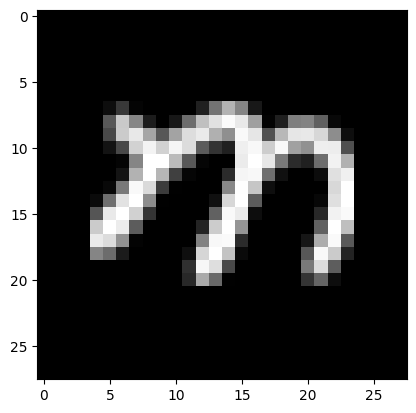

In [ ]:
example = X_train[20]

prediction = model.predict(example.reshape(1, 28, 28, 1))
print("\n\nFinal Output: {}".format(np.argmax(prediction)))
decoder_label([np.argmax(prediction)])

plt.imshow(example.reshape(28, 28), cmap="gray")
plt.show()

In [ ]:
# Giả sử model là mô hình CNN đã huấn luyện, X_test và y_test là dữ liệu kiểm thử

# Đánh giá mô hình
y_pred = model.predict(X_test)
# Dự đoán xác suất trên tập kiểm thử
y_score = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = Y_test.argmax(axis=1)

2328/2328 [==============================] - 5s 2ms/step


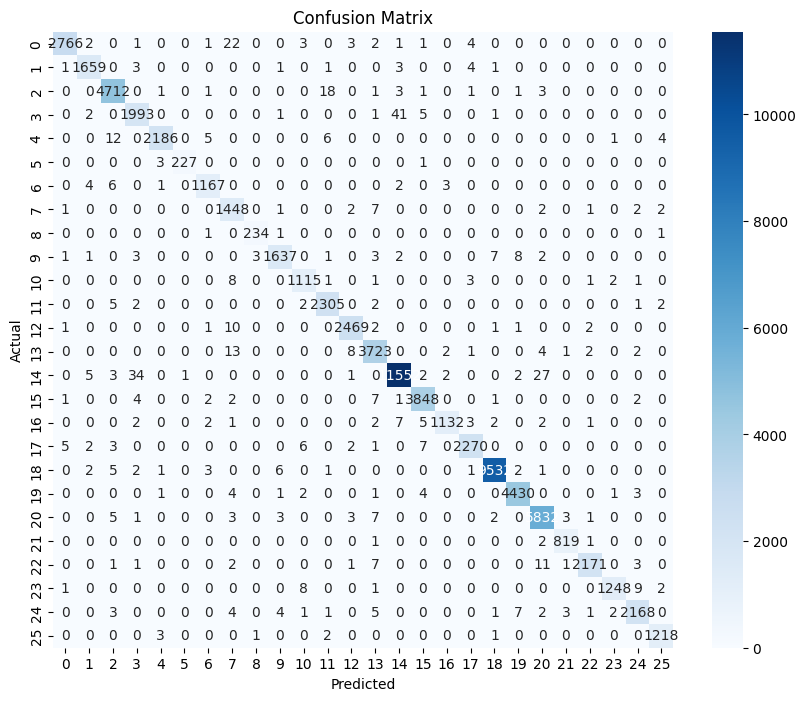

In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Minh họa xử lý ảnh và chuẩn bị số liệu (Not care about it)

In [ ]:
    # Đọc ảnh vào
    img_path = '/content/drive/My Drive/Colab Notebooks/XuLyAnh/BTL/test6.png'
    img = cv2.imread(img_path)
    img1 = cv2.imread(img_path,0)

    # Resize ảnh
    resized_img = cv2.resize(img1, (4250, 3450))

    # Hiển thị ảnh gốc
    print('original_image')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Hiển thị ảnh xám
    print('\n\ngrayscale_image')
    plt.imshow(img1)
    plt.show()

    # Hiển thị ảnh resize
    print('\n\nresized_image')
    plt.imshow(resized_img)
    plt.show()

    # Cắt ảnh
    crop_img = resized_img[1000:2500, 250:4000]

    # Hiển thị ảnh đã cắt
    print('\n\ncrop_image')
    plt.imshow(crop_img)
    plt.show()

    # Gaussian blur, Otsu's threshold
    blur = cv2.GaussianBlur(crop_img, (5,5), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # xử lý điểm ảnh nhỏ
    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 800:
            cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

    # Hiển thị ảnh sau xử lý Gaussian blur
    print('\n\nGaussian blur')
    plt.imshow(blur)
    plt.show()

    # Hiển thị ảnh sau xử lý Otsu's threshold và điểm ảnh nhỏ
    print('\n\nOtsu threshold')
    plt.imshow(thresh)
    plt.show()


# Sắp xếp viền theo trục x.

In [ ]:
def x_cord_contour(contours):
    if cv2.contourArea(contours) > 10:
        M = cv2.moments(contours)
        return (int(M['m10']/M['m00']))
    else:
        pass

# Hàm cắt ảnh và hiển thị kết quả từ ảnh được chọn.

In [ ]:
def crop_define(path):

    # Đọc và biểu diễn ảnh từ đường dẫn:
    img = cv2.imread(path)
    img1 = cv2.imread(path,0)

    resized_img = cv2.resize(img1, (4250, 3450))

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # x,y là chỉ số tọa độ trục x và y, w là width, h là height.
    crop_img = resized_img[1000:2500, 250:4000] #[y:y+h, x:x+w]

    reco_letters(crop_img) # Kết quả

# Hàm nhận dạng chữ cái và xuất file.

In [ ]:
def reco_letters(img):

    # Gaussian blur, Otsu's threshold
    blur = cv2.GaussianBlur(img, (5,5), 0) # Lọc trung bình
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] #Phân ngưỡng tự động tách viền

    # xử lý điểm ảnh nhỏ, lọc nhiễu
    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 800:
            cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

    # findContour dùng để cung cấp đường viền từng chữ cái trên ảnh.
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sắp xếp đường viền từ trái sang phải dựa trên hàm sắp xếp đường viền theo trục x.
    contours_left_to_right = sorted(contours, key = x_cord_contour, reverse = False)

    preprocessed_letter = []

    for (i,c)  in enumerate(contours_left_to_right):
        (x, y, w, h) = cv2.boundingRect(c)

        # tạo viền quanh chữ cái trong ảnh.
        cv2.rectangle(img, (x,y), (x+w, y+h), color=(0,0,0), thickness=2)

        # cắt ảnh và xử lý
        digit = thresh[y:y+h, x:x+w]

        # chuyển về size(18,18)
        resized_digit = cv2.resize(digit, (18,18))

        # thêm padding 5 pixel màu đen vào 4 góc để chuyển ảnh về (28,28)
        padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)

        # lưu trữ vào preprocessed_letter
        preprocessed_letter.append(padded_digit)

    # Biểu diễn ảnh sau khi tìm được viền các chữ.
    print("\n\n\n")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    # Dự đoán kết quả.
    processed_letter = []

    for digit in preprocessed_letter:
        prediction = model.predict(digit.reshape(1, 28, 28, 1))

        processed_letter.append(np.argmax(prediction))

    # In các chữ cái cần nhận dạng: (Kết quả)
    arr = np.array(processed_letter)
    print('Kết quả nhận dạng mã hóa: ',arr)
    decoder_label(arr)


# Test chương trình với một số bằng tốt nghiệp.

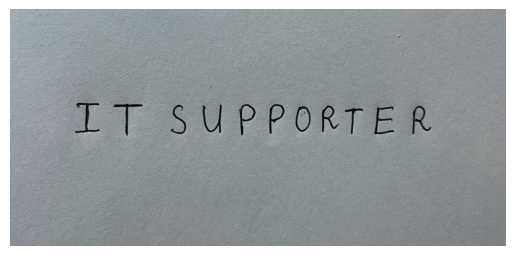

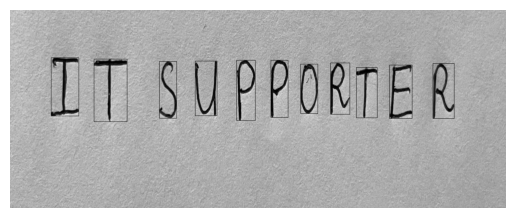

1/1 [==============================] - 0s 28ms/step
Kết quả nhận dạng mã hóa:  [ 8 19 18 20 15 15 14 17 19  4 17]
Kết quả nhận dạng giải mã:  itsupporter


In [ ]:
crop_define('/content/drive/My Drive/Colab Notebooks/XuLyAnh/BTL/test5.png')

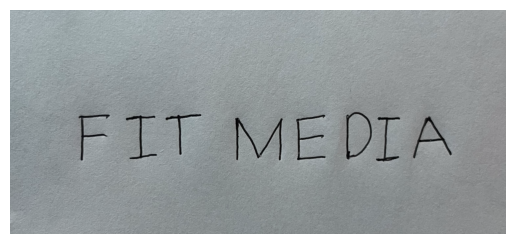

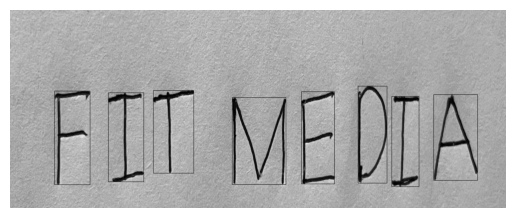

1/1 [==============================] - 0s 18ms/step
Kết quả nhận dạng mã hóa:  [ 5  8 19 12  4  3  8  0]
Kết quả nhận dạng giải mã:  fitmedia


In [ ]:
crop_define('/content/drive/My Drive/Colab Notebooks/XuLyAnh/BTL/test6.png')

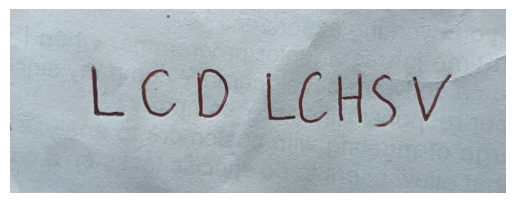

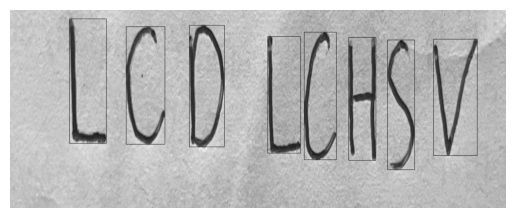

1/1 [==============================] - 0s 18ms/step
Kết quả nhận dạng mã hóa:  [11  2  3 11  2  7 18 21]
Kết quả nhận dạng giải mã:  lcdlchsv


In [ ]:
crop_define('/content/drive/My Drive/Colab Notebooks/XuLyAnh/BTL/test7.png')

#Link full project

https://drive.google.com/drive/folders/1BDu3baDpv42pB5ISQV-zLcyavcS_q3T3?usp=sharing